# Generating Digits Using A Variational AutoEncoder

## Creating A Variational AutoEncoder

### Import Necessary Libraries

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

### Define Paramaters And A Sampling Layer

In [2]:
num_units_hidden_1 = 500
num_units_hidden_2 = 500
num_units_hidden_3 = 20
num_units_hidden_4 = num_units_hidden_2
num_units_hidden_5 = num_units_hidden_1

initializer = tf.keras.initializers.VarianceScaling()
params = {
    'activation': 'elu',
    'kernel_initializer': initializer
}

class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, gamma = inputs
        return K.random_normal(tf.shape(gamma)) * K.exp(gamma / 2) + mean

### Define Encoder Model

In [3]:
encoder_input_layer = Input(shape = (28 * 28, ))

hidden_1 = Dense(num_units_hidden_1, **params)(encoder_input_layer)
hidden_2 = Dense(num_units_hidden_2, **params)(hidden_1)

mean  = Dense(num_units_hidden_3, activation = None)(hidden_2)
gamma = Dense(num_units_hidden_3, activation = None)(hidden_2)
codings = Sampling()([mean, gamma])

encoder = Model(inputs = [encoder_input_layer], outputs = [mean, gamma, codings])

### Define Decoder Model

In [4]:
decoder_input_layer = Input(shape = (20, ))

hidden_3 = Dense(num_units_hidden_4, **params)(decoder_input_layer)
hidden_4 = Dense(num_units_hidden_5, **params)(hidden_3)
output_layer = Dense(28 * 28, activation = 'sigmoid')(hidden_4)

decoder = Model(inputs = [decoder_input_layer], outputs = [output_layer])

### Define Variational Autoencoder From Encoders And Decoders

In [5]:
_, _, encodings = encoder(encoder_input_layer)
reconstructions = decoder(encodings)
vae_model = Model(inputs = [encoder_input_layer], outputs = [reconstructions])

### Define The Loss Function, And Compile The Model With An Adam Optimizer

In [6]:
latent_loss = -0.5 * K.sum(1 + gamma - K.exp(gamma) - K.square(mean), axis = -1)
vae_model.add_loss(K.mean(latent_loss) / 784.)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
vae_model.compile(optimizer = optimizer, loss = 'binary_crossentropy')

## MNIST dataset

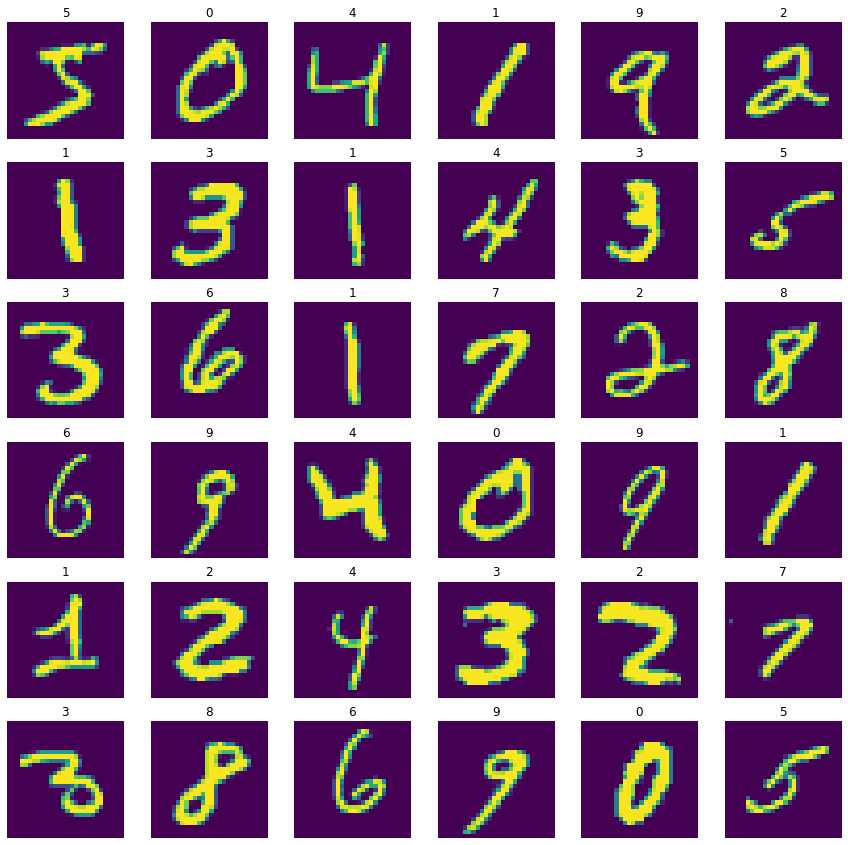

In [10]:
import matplotlib.pyplot as plt
import numpy as np

mnist_dataset = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()
train_images, test_images = train_images / 255, test_images / 255

fig, axes = plt.subplots(6, 6, figsize = (15, 15))

for row in range(0, 6):
    for col in range(0, 6):
        current_image = train_images[6 * row + col]
        axes[row, col].set_title(train_labels[6 * row + col])
        axes[row, col].axis('off')
        axes[row, col].imshow(current_image)
        
train_images = train_images.reshape((-1, 28 * 28))
test_images  = test_images.reshape((-1, 28 * 28))
images = np.vstack((train_images, test_images))

plt.show()

## Training

In [8]:
fit_params = {
    'epochs': 15,
    'batch_size': 64
}
history = vae_model.fit(images, images, **fit_params)

Train on 70000 samples
Epoch 1/15
70000/70000 [==============================] - 28s 394us/sample - loss: 0.1636
Epoch 2/15
70000/70000 [==============================] - 24s 342us/sample - loss: 0.1426
Epoch 3/15
70000/70000 [==============================] - 24s 345us/sample - loss: 0.1391
Epoch 4/15
70000/70000 [==============================] - 26s 366us/sample - loss: 0.1370
Epoch 5/15
70000/70000 [==============================] - 37s 524us/sample - loss: 0.1357
Epoch 6/15
70000/70000 [==============================] - 41s 591us/sample - loss: 0.1348
Epoch 7/15
70000/70000 [==============================] - 33s 466us/sample - loss: 0.1337
Epoch 8/15
70000/70000 [==============================] - 33s 470us/sample - loss: 0.1331
Epoch 9/15
70000/70000 [==============================] - 34s 482us/sample - loss: 0.1325
Epoch 10/15
70000/70000 [==============================] - 24s 343us/sample - loss: 0.1319
Epoch 11/15
70000/70000 [==============================] - 24s 338us/sample 

## Results

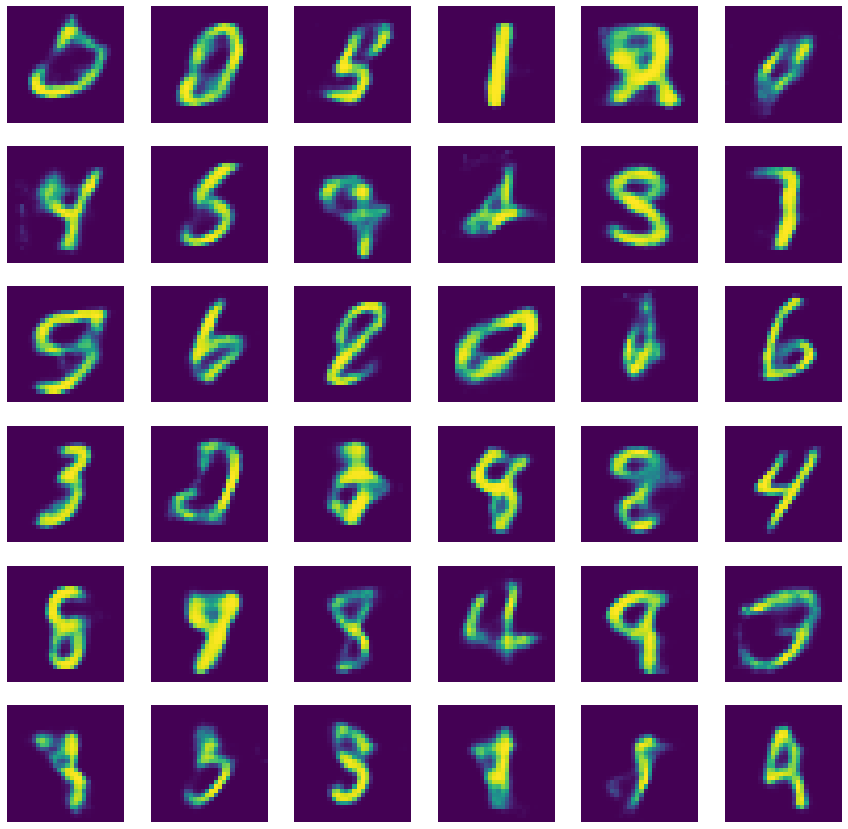

In [9]:
input_codings = np.random.normal(size = [60, num_units_hidden_3])
generated_images = decoder.predict(input_codings)

fig, axes = plt.subplots(6, 6, figsize = (15, 15))
i = 0
for row in range(0, 6):
    for col in range(0, 6):
        current_image = np.array(generated_images[i]).reshape(28, 28)
        axes[row, col].axis('off')
        axes[row, col].imshow(current_image)
        i += 1

plt.show()